# Clasificación con Árboles de Decisión

En este notebook, abordamos un problema de clasificación multietiqueta utilizando árboles de decisión. Nuestro objetivo es predecir la probabilidad de vacunación contra el H1N1 y la gripe estacional. A continuación, describimos el proceso en detalle.

El algoritmo que vamos a utilizar es el árbol de decisión CART (Classification and Regression Trees). Lo aplicaremos con DecisionTreeClassifier de Scikit-learn que hace referencia al árbol de clasificación. Este árbol divide el espacio de características en regiones disjuntas mediante divisiones binarias (cada nodo tiene a lo sumo dos hijos).

In [1]:
import pandas as pd
import os
import joblib
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree

## 1. Importar los datos

Cargamos los datos preprocesados y divididos tras aplicar train_test_split. El dataset ya ha sido tratado para manejar valores faltantes y aplicar codificaciones necesarias.

In [2]:
# Cargar datos
X_train = pd.read_csv("../../Data/preprocessed_X_train.csv", index_col="respondent_id")
X_test = pd.read_csv("../../Data/preprocessed_X_test.csv", index_col="respondent_id")
y_train = pd.read_csv("../../Data/preprocessed_y_train.csv", index_col="respondent_id")
y_test = pd.read_csv("../../Data/preprocessed_y_test.csv", index_col="respondent_id")

## 2. Entrenar un árbol de decisión

Utilizamos el modelo DecisionTreeClassifier de Scikit-Learn y lo envolvemos en un MultiOutputClassifier para manejar el problema multietiqueta. Realizamos una búsqueda de hiperparámetros utilizando GridSearchCV.

In [3]:
# Modelo base: DecisionTreeClassifier
cart_model = DecisionTreeClassifier(random_state=42)

# Envolver en MultiOutputClassifier para clasificación multietiqueta
multi_cart = MultiOutputClassifier(cart_model)

In [6]:
# Espacio de búsqueda
param_grid = {
    'estimator__criterion': ['gini', 'entropy'],
    'estimator__splitter': ['best', 'random'],
    'estimator__max_depth': [3, 5, 10, None],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 5],
    'estimator__max_features': [None, 'sqrt', 'log2'],
    'estimator__max_leaf_nodes': [None, 10, 20, 50],
}

# Búsqueda de hiperparámetros
opt = GridSearchCV(multi_cart, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Entrenar el modelo con optimización
opt.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros:", opt.best_params_)
print("Mejor puntaje (AUROC):", opt.best_score_)

Mejores hiperparámetros: {'estimator__criterion': 'entropy', 'estimator__max_depth': None, 'estimator__max_features': None, 'estimator__max_leaf_nodes': 50, 'estimator__min_samples_leaf': 5, 'estimator__min_samples_split': 2, 'estimator__splitter': 'best'}
Mejor puntaje (AUROC): 0.8391826436720887


## 3. Evaluar el modelo

Calculamos métricas de rendimiento clave, como precisión, recall, F1-score y nuestra métrica principal AUROC para ambas etiquetas.

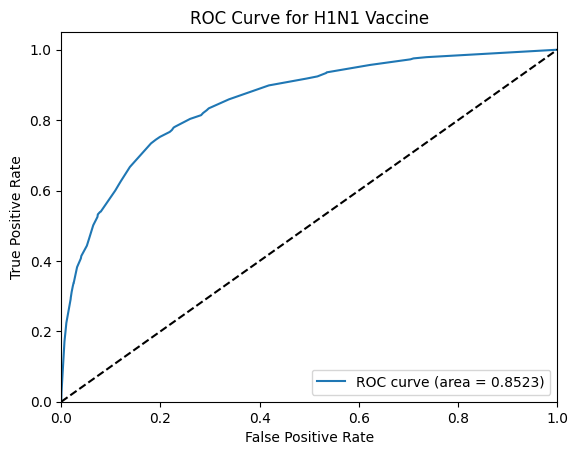

In [7]:
# Predicciones y probabilidades
y_pred = opt.best_estimator_.predict(X_test)
y_proba = opt.best_estimator_.predict_proba(X_test)

# Evaluación para H1N1
h1n1_probabilities = y_proba[0][:, 1]
h1n1_predictions = y_pred[:, 0]
roc_auc_h1n1 = roc_auc_score(y_test['h1n1_vaccine'], h1n1_probabilities)
accuracy_h1n1 = accuracy_score(y_test['h1n1_vaccine'], h1n1_predictions)

# Curva ROC para H1N1
fpr_h1n1, tpr_h1n1, _ = roc_curve(y_test['h1n1_vaccine'], h1n1_probabilities)
plt.figure()
plt.plot(fpr_h1n1, tpr_h1n1, label=f'ROC curve (area = {roc_auc_h1n1:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for H1N1 Vaccine')
plt.legend(loc="lower right")
plt.show()

In [8]:
print(f"AUROC para H1N1: {roc_auc_h1n1}")
print(f"Accuracy para H1N1: {accuracy_h1n1}")

AUROC para H1N1: 0.8522617538003054
Accuracy para H1N1: 0.8410707600149757


In [9]:
# Generar y mostrar el classification report para H1N1
print("Classification Report for H1N1 Vaccine:")
print(classification_report(y_test['h1n1_vaccine'], h1n1_predictions, target_names=["No", "Yes"]))

Classification Report for H1N1 Vaccine:
              precision    recall  f1-score   support

          No       0.86      0.95      0.90      4207
         Yes       0.70      0.44      0.54      1135

    accuracy                           0.84      5342
   macro avg       0.78      0.70      0.72      5342
weighted avg       0.83      0.84      0.83      5342



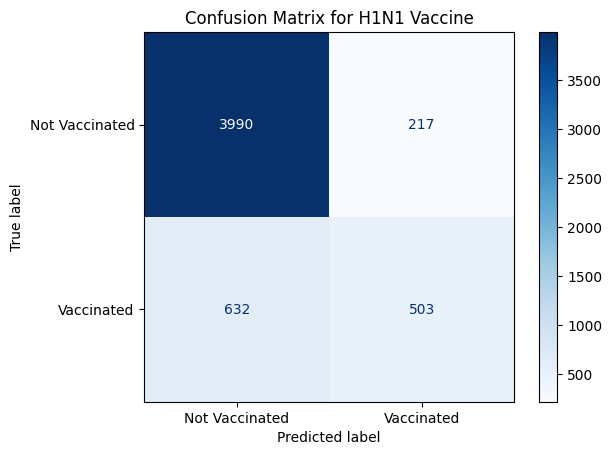

In [10]:
# Matriz de confusión del modelo
conf_matrix= confusion_matrix(y_test['h1n1_vaccine'], h1n1_predictions)
disp= ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Not Vaccinated', 'Vaccinated'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for H1N1 Vaccine")
plt.show()

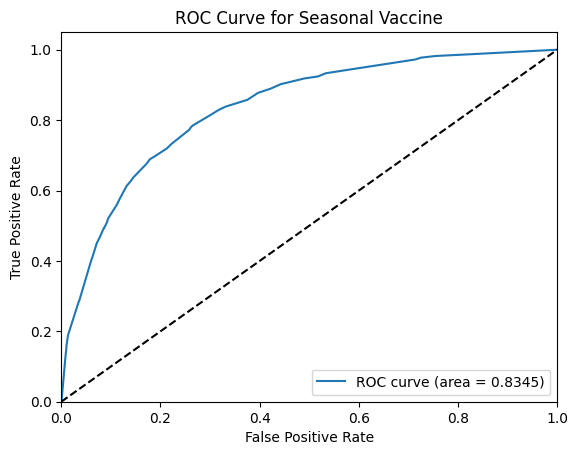

In [11]:
# Evaluación para Vacuna Estacional
seasonal_probabilities = y_proba[1][:, 1]
seasonal_predictions = y_pred[:, 1]
roc_auc_seasonal = roc_auc_score(y_test['seasonal_vaccine'], seasonal_probabilities)
accuracy_seasonal = accuracy_score(y_test['seasonal_vaccine'], seasonal_predictions)

# Curva ROC para Vacuna Estacional
fpr_seasonal, tpr_seasonal, _ = roc_curve(y_test['seasonal_vaccine'], seasonal_probabilities)
plt.figure()
plt.plot(fpr_seasonal, tpr_seasonal, label=f'ROC curve (area = {roc_auc_seasonal:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Seasonal Vaccine')
plt.legend(loc="lower right")
plt.show()

In [12]:
print(f"AUROC para Vacuna Estacional: {roc_auc_seasonal}")
print(f"Accuracy para Vacuna Estacional: {accuracy_seasonal}")

AUROC para Vacuna Estacional: 0.8345403416426879
Accuracy para Vacuna Estacional: 0.7579558217895919


In [13]:
# Generar y mostrar el classification report para seasonal
print("Classification Report for seasonal Vaccine:")
print(classification_report(y_test['seasonal_vaccine'], seasonal_predictions, target_names=["No", "Yes"]))

Classification Report for seasonal Vaccine:
              precision    recall  f1-score   support

          No       0.76      0.81      0.78      2854
         Yes       0.76      0.70      0.73      2488

    accuracy                           0.76      5342
   macro avg       0.76      0.75      0.76      5342
weighted avg       0.76      0.76      0.76      5342



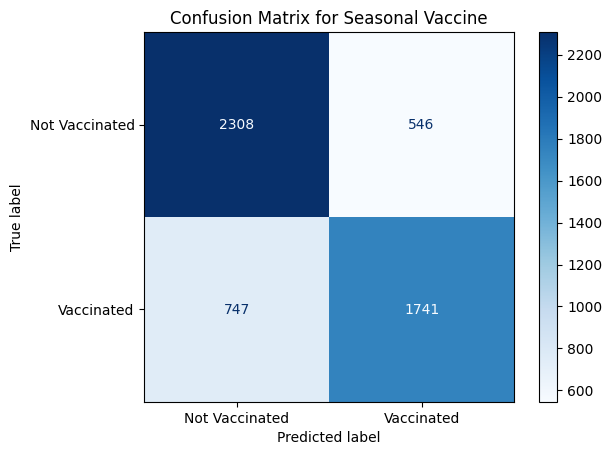

In [21]:
# Matriz de confusión para Vacuna Estacional
conf_matrix_seasonal = confusion_matrix(y_test['seasonal_vaccine'], seasonal_predictions)
disp_seasonal = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_seasonal, display_labels=['Not Vaccinated', 'Vaccinated'])
disp_seasonal.plot(cmap='Blues')
plt.title("Confusion Matrix for Seasonal Vaccine")
plt.show()

# 4. Visualizar el árbol de decisión

Visualizar el árbol nos ayuda a comprender cómo se toman las decisiones.

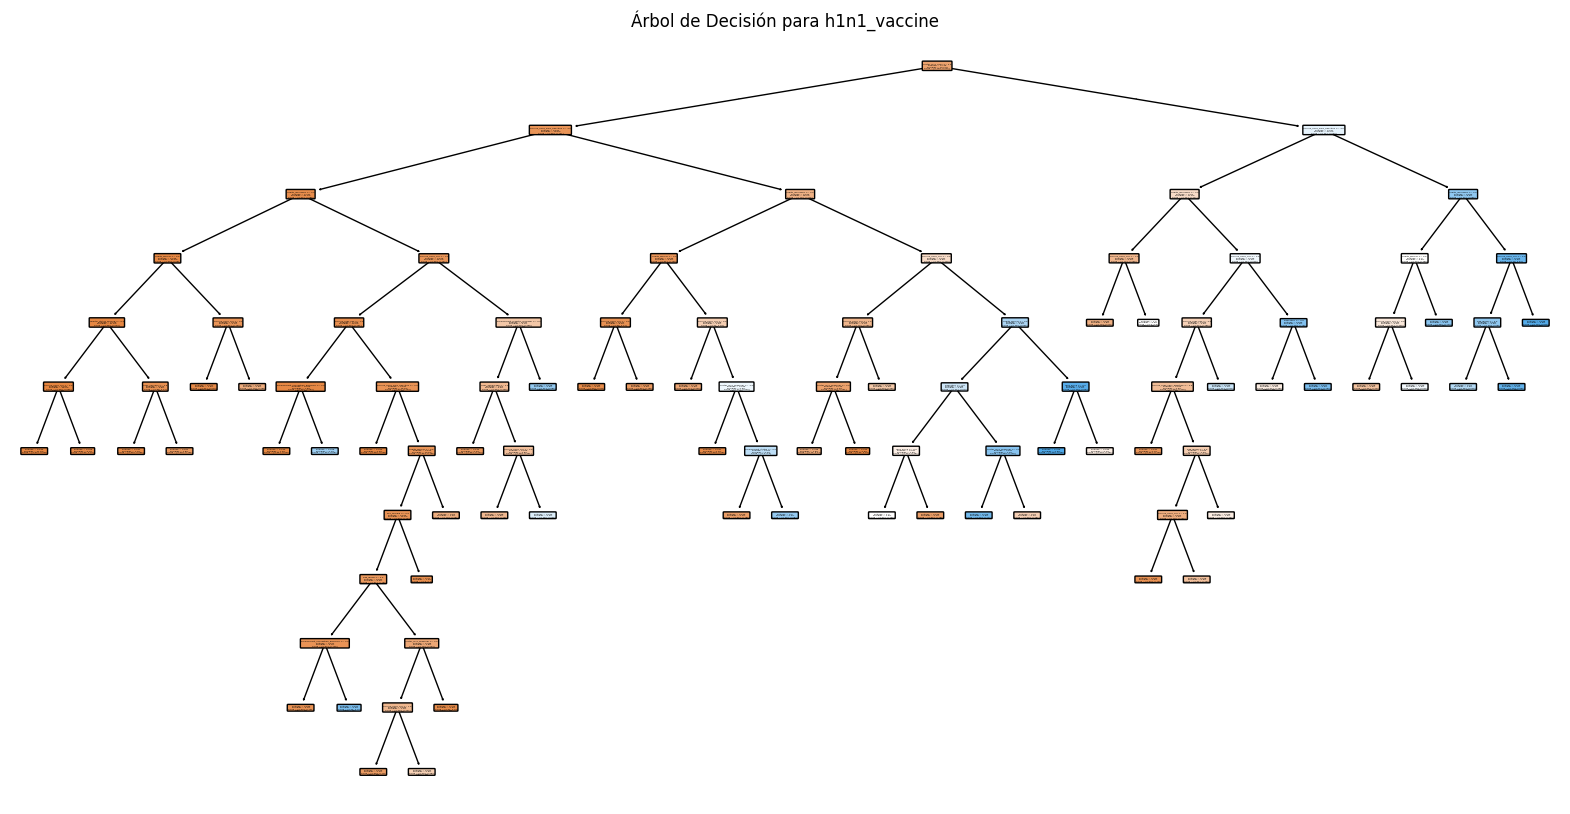

In [15]:
# Obtener el modelo optimizado
best_tree_h1n1 = opt.best_estimator_.estimators_[0]

# Visualizar el árbol
plt.figure(figsize=(20, 10))
plot_tree(
    best_tree_h1n1,
    filled=True,
    feature_names=X_train.columns,  # Nombres de las características
    class_names=["No", "Yes"],      # Etiquetas de las clases
    rounded=True,
    proportion=True
)
plt.title("Árbol de Decisión para h1n1_vaccine")
plt.show()

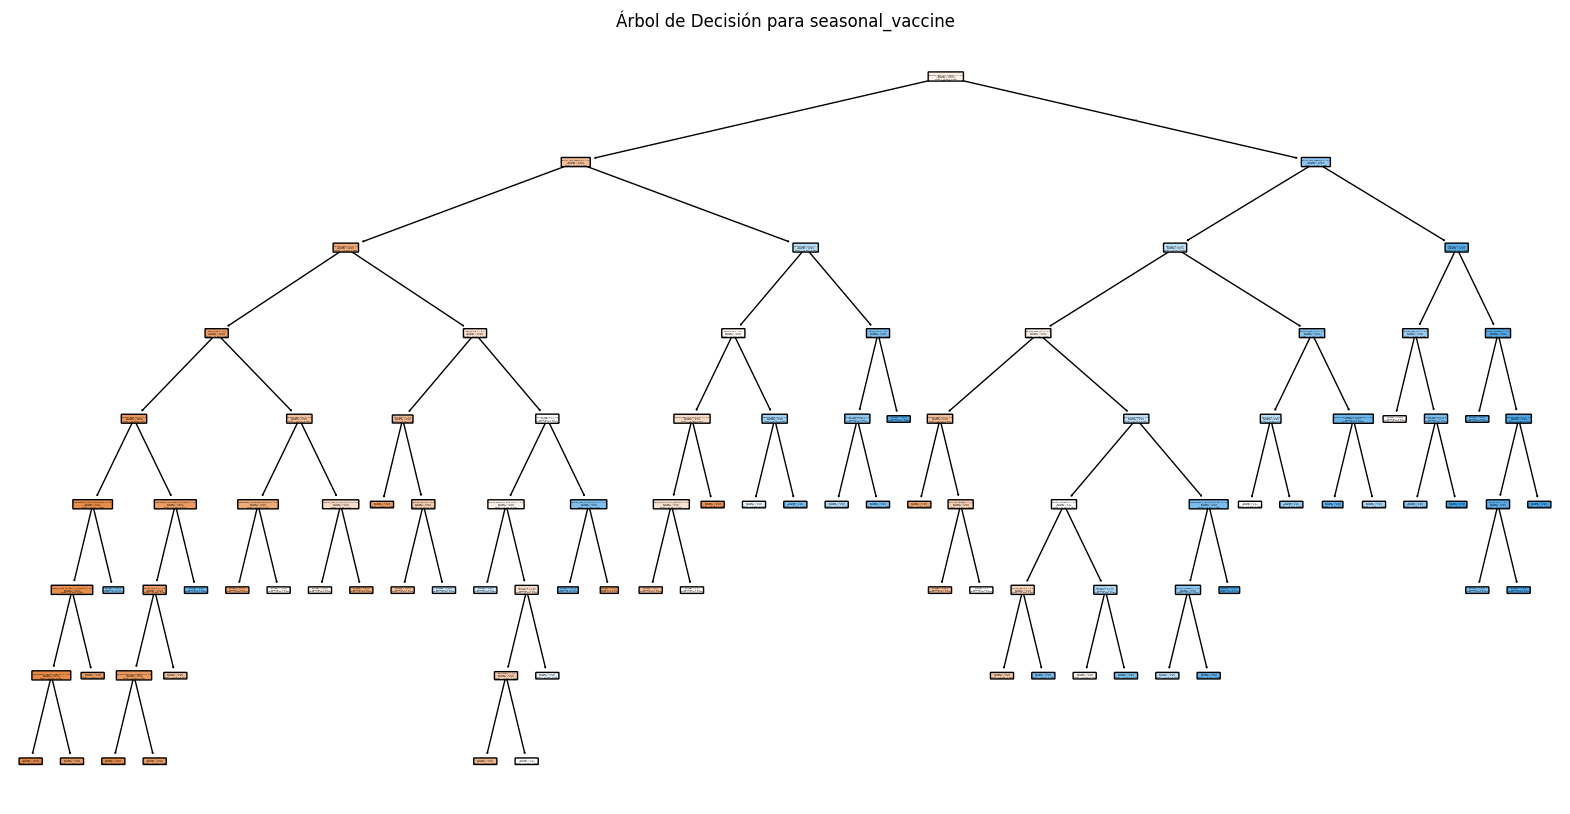

In [16]:
# Árbol para la segunda etiqueta (seasonal_vaccine)
best_tree_seasonal = opt.best_estimator_.estimators_[1]

# Visualizar el árbol
plt.figure(figsize=(20, 10))
plot_tree(
    best_tree_seasonal,
    filled=True,
    feature_names=X_train.columns,
    class_names=["No", "Yes"],
    rounded=True,
    proportion=True
)
plt.title("Árbol de Decisión para seasonal_vaccine")
plt.show()

## 5. Guardar el modelo

Si el modelo supera las métricas del modelo anterior lo guardamos para tener el mejor modelo siempre guardado.

In [17]:
def save_model_if_better(model, current_roc_auc, model_path, metric_path):

    # Cargar la métrica del modelo previo si existe
    if os.path.exists(metric_path):
        with open(metric_path, "r") as f:
            best_roc_auc = float(f.read().strip())
    else:
        best_roc_auc = 0.0
    
    print(f"Current ROC AUC: {current_roc_auc:.4f} | Best ROC AUC: {best_roc_auc:.4f}")

    # Comparar y guardar el modelo si mejora
    if current_roc_auc > best_roc_auc:
        print("El modelo es mejor que el anterior...")
        joblib.dump(model, model_path)  # Guardar el modelo
        with open(metric_path, "w") as f:
            f.write(f"{current_roc_auc:.4f}")  # Guardar la métrica actual
    else:
        print("El modelo no es mejor que el anterior. Saltando el guardado.")

In [18]:
current_roc_auc = (roc_auc_seasonal + roc_auc_h1n1) / 2
model_path = "Modelos/DecissionTree_best_model.pkl"
metric_path = "Modelos/DecissionTree_best_roc_auc.txt"
save_model_if_better(opt.best_estimator_, current_roc_auc, model_path, metric_path)

Current ROC AUC: 0.8434 | Best ROC AUC: 0.8385
El modelo es mejor que el anterior...


## 6. Generar el archivo de envío a la competición

Para generar el archivo de envío, aplicamos el modelo al dataset de prueba y creamos un archivo .csv con las predicciones.

In [20]:
# Cargar el dataset de prueba preprocesado
test_set_preprocessed = pd.read_csv("../../Data/preprocessed_test_set_features.csv")

# Asegurarse de que respondent_id esté disponible
respondent_ids = test_set_preprocessed['respondent_id']

# Eliminar respondent_id del conjunto de características
X_test_final = test_set_preprocessed.drop(columns=['respondent_id'])

# Realizar predicciones de probabilidad
y_proba_test = opt.best_estimator_.predict_proba(X_test_final)

# Extraer las probabilidades para la clase positiva (1)
y_proba_h1n1_test = y_proba_test[0][:, 1] 
y_proba_seasonal_test = y_proba_test[1][:, 1]

# Crear el DataFrame de submission
submission = pd.DataFrame({
    "respondent_id": respondent_ids,
    "h1n1_vaccine": y_proba_h1n1_test,
    "seasonal_vaccine": y_proba_seasonal_test
})

# Guardar el archivo de submission
submission.to_csv("Submissions/DecisionTree_submission.csv", index=False)
print("Archivo 'DecisionTree_submission.csv' generado correctamente.")

Archivo 'DecisionTree_submission.csv' generado correctamente.
